# Conformally mapped body

In [1]:
using PotentialFlow

INFO: Recompiling stale cache file /Users/jeff/.julia/lib/v0.6/PotentialFlow.ji for module PotentialFlow.


## Set up

Create a body shape from a power series conformal map

In [2]:
a1 = 1; b1 = 1; ccoeff = Complex128[0.5(a1+b1),0,0.5(a1-b1)]
b = Bodies.ConformalBody(ccoeff)

Body generated by: Power series map

  centroid at 0.0 + 0.0im
  angle 0.0


In [9]:
n = 6; dθ = 2π/(2n)
θ = collect(0:dθ:2π-dθ)
w = (1+0.3cos.(n*θ)).*exp.(im*θ)
p = Bodies.Polygon(w)
b = Bodies.ConformalBody(p)

Body generated by: Schwarz-Christoffel map of unit circle to exterior of polygon with 12 vertices

  centroid at 0.0 + 0.0im
  angle 0.0


In [3]:
using Plots
clibrary(:colorbrewer)
default(grid = false)

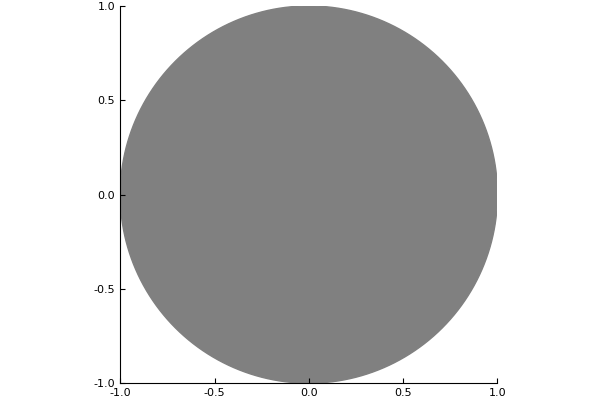

In [4]:
plot(b,fillcolor=:grey,linecolor=:grey)

In [112]:
plate = Plates.Plate(256,2.0,Complex128(0),π/4)

Plate: N = 256, L = 2.0, c = 0.0 + 0.0im, α = 45.0ᵒ
       LESP = 0.0, TESP = 0.0

In [29]:
p = Bodies.Polygon([-1.0,1.0,1.0,-1.0],[-1.0,-1.0,1.0,1.0])
b = Bodies.ConformalBody(p)

Body generated by: Schwarz-Christoffel map of unit circle to exterior of polygon with 4 vertices

  centroid at 0.0 + 0.0im
  angle 0.0


In [41]:
sys = (Vortex.Point(1.0im, π), Vortex.Blob(2.0im, -π, 0.1));
b = Bodies.ConformalBody(Complex128[1/4,0,1/4]);
Elements.conftransform(sys,b)

(0.0 + 0.0im, 0.0 + 0.375im)

In [44]:
dz, ddz = b.dm(1.0im)

(0.5 + 0.0im, 0.0 + 0.5im)

In [10]:
ċ = 0.0im
motion = RigidBodyMotion(ċ, 1.0);

In [11]:
Δt = 1.0;
b₊ = deepcopy(b)
advect!(b₊,b,motion,Δt)
b₊.α

1.0

In [46]:
vp1 = Vortex.Point.([1.1im,-2.3-1.0im,5.3im], 1.0)

3-element Array{PotentialFlow.Points.Point{Float64},1}:
 Vortex.Point(0.0 + 1.1im, 1.0) 
 Vortex.Point(-2.3 - 1.0im, 1.0)
 Vortex.Point(0.0 + 5.3im, 1.0) 

In [47]:
vp2 = Vortex.Point.([1.3,-3.1-1.0im,3.3im], -1.0)

3-element Array{PotentialFlow.Points.Point{Float64},1}:
 Vortex.Point(1.3 + 0.0im, -1.0) 
 Vortex.Point(-3.1 - 1.0im, -1.0)
 Vortex.Point(0.0 + 3.3im, -1.0) 

In [53]:
Bodies.enforce_no_flow_through!(b,motion,Vortex.Point[],0.0)

In [49]:
sys = (b,vp1,vp2)

(Body generated by: Power series map

  centroid at 0.0 + 0.0im
  angle 0.0
, PotentialFlow.Points.Point{Float64}[Vortex.Point(0.0 + 1.1im, 1.0), Vortex.Point(-2.3 - 1.0im, 1.0), Vortex.Point(0.0 + 5.3im, 1.0)], PotentialFlow.Points.Point{Float64}[Vortex.Point(1.3 + 0.0im, -1.0), Vortex.Point(-3.1 - 1.0im, -1.0), Vortex.Point(0.0 + 3.3im, -1.0)])

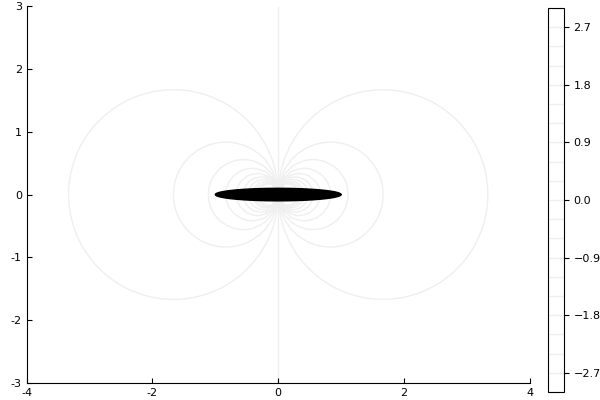

In [54]:
streamlines(-4:0.1:4, -3:0.1:3, b, clim = (-3, 3), levels = collect(-3:0.3:3), color = cgrad(["#efefef", "#efefef"]))
plot!(b)

Test the no-penetration condition at points on the body

In [8]:
ζ = exp(-im*π/4)
dz, ddz = b.dm(ζ)
sys = (b,vp1,vp2)
Bodies.normal(ζ,induce_velocity(ζ,sys,0)/conj(dz)-ċ,b)

4.882188713933115e-17

In [10]:
z = Complex128(-1.1)
streamfunction(z,b,vp,0.0)

(Vortex.Point(2.3 + 0.0im, 1.0), Vortex.Point(0.4347826086956522 + 0.0im, -1.0))


-0.1265897223663215

In [101]:
w = SchwarzChristoffel.naca4(0.1,0.4,0.12;len=2)
p = Bodies.Polygon(w);

In [17]:
ċ = 1.0
motion = RigidBodyMotion(ċ, 0.0);

In [18]:
Bodies.enforce_no_flow_through!(b,motion,(vp1,vp2),0.0)

In [21]:
ζ = exp(im*π/4)
dz, ddz = b.dm(ζ)
sys = (b,vp1,vp2)
real((induce_velocity(ζ,sys,0)/conj(dz)-ċ)*conj(ζ*dz)/abs(dz))

-4.864657457382513e-17

In [20]:
induce_velocity(ζ,sys,0)

0.28470959943201263 - 1.315380004696449im

In [12]:
streamfunction(z,b)

0.014405876191776143

In [13]:
z = Complex128[-1.1,2.0+2.0im,3.0-0.2im]
streamfunction(z,b)

3-element Array{Float64,1}:
 0.0144059 
 0.233941  
 0.00515583

In [45]:
plot_streamlines(sys;scalefactor=4.0)

8.0


LoadError: [91mUndefVarError: b not defined[39m

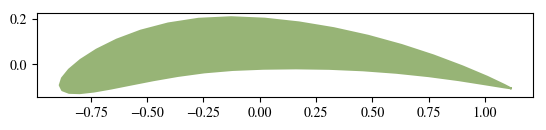

In [27]:
SchwarzChristoffel.plot(p)

In [15]:
b.α̇

0.0

In [84]:
sys = (b,vp1,vp2)

(Body generated by: Schwarz-Christoffel map of unit circle to exterior of polygon with 12 vertices

  centroid at 0.0 + 0.0im
  angle 0.0
, PotentialFlow.Points.Point{Float64}[Vortex.Point(0.0 + 1.1im, 1.0), Vortex.Point(-2.3 - 1.0im, 1.0), Vortex.Point(0.0 + 5.3im, 1.0)], PotentialFlow.Points.Point{Float64}[Vortex.Point(1.3 + 0.0im, -1.0), Vortex.Point(-3.1 - 1.0im, -1.0), Vortex.Point(0.0 + 3.3im, -1.0)])

# Testing advection

In [13]:
function compute_ẋ!(ẋ, x, t)
    body, ambient_sys = x
    motion = ẋ[1]
    motion.ċ, motion.c̈, motion.α̇ = motion.kin(t)
    
    Bodies.enforce_no_flow_through!(body, motion, ambient_sys, t)
    reset_velocity!(ẋ, x)
    self_induce_velocity!(ẋ, x, t)
    Bodies.transform_velocity!(ẋ, ẋ, x, body)
end

compute_ẋ! (generic function with 1 method)

### Elliptical bodies

In [33]:
a1 = 1; b1 = 0.1; ccoeff = Complex128[0.5(a1+b1),0,0.5(a1-b1)]
c = Complex128(0)
α = π/4
b = Bodies.ConformalBody(ccoeff,c,α)

Body generated by: Power series map

  centroid at 0.0 + 0.0im
  angle 0.7854


In [82]:
p = Bodies.Polygon([-0.5,0.5],[0,0]);
b = Bodies.ConformalBody(p)

Body generated by: Schwarz-Christoffel map of unit circle to exterior of polygon with 2 vertices

  centroid at 0.0 + 0.0im
  angle 0.0


### Star-shaped bodies

In [36]:
n = 6; dθ = 2π/(2n)
θ = collect(0:dθ:2π-dθ)
w = (1+0.3cos.(n*θ)).*exp.(im*θ)
p = Bodies.Polygon(w)
b = Bodies.ConformalBody(p)

Body generated by: Schwarz-Christoffel map of unit circle to exterior of polygon with 12 vertices

  centroid at 0.0 + 0.0im
  angle 0.0


### NACA airfoils

In [117]:
w = SchwarzChristoffel.naca4(0.1,0.4,0.12;len=1)
p = Bodies.Polygon(w);
b = Bodies.ConformalBody(p)

Body generated by: Schwarz-Christoffel map of unit circle to exterior of polygon with 39 vertices

  centroid at 0.0 + 0.0im
  angle 0.0


In [47]:
ċ = 0.0
α̇ = 0.0
Δt = 5e-3; # time step
motion = RigidBodyMotion(ċ, α̇);

In [92]:
vp1 = Vortex.Point.([-2.0+0.2im,-2.0-0.2im], [1.0,-1.0])

2-element Array{PotentialFlow.Points.Point{Float64},1}:
 Vortex.Point(-2.0 + 0.2im, 1.0) 
 Vortex.Point(-2.0 - 0.2im, -1.0)

In [93]:
ambient_sys = inverse_conftransform(vp1,b)
orig_sys = deepcopy(ambient_sys)
sys = (b, ambient_sys)
sys₊ = deepcopy(sys) # Used for storage during time-marching
ẋs = [(motion, allocate_velocity(ambient_sys)) for k = 1:4];

In [131]:
tf = 0.5
T = 0:Δt:tf-Δt

for t in T
    b, ambient_ω = sys
    #motion, ambient_u = ẋs
    
    TimeMarching.rk4!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)
    
    sys₊, sys = sys, sys₊
end
b, final_ω = sys;
ambient_ω_z = conftransform(final_ω,b)

2-element Array{PotentialFlow.Points.Point{Float64},1}:
 Vortex.Point(0.03612199802788485 + 1.4307559666772167im, 1.0)
 Vortex.Point(0.4364668283420259 + 1.4695948894870257im, -1.0)

In [17]:
using Plots
clibrary(:colorbrewer)
default(grid = false)

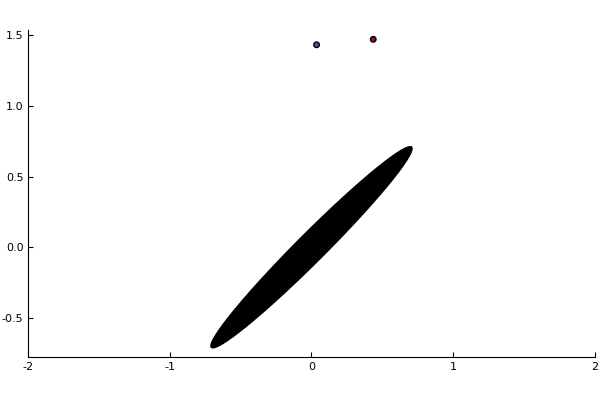

In [132]:
plot((b,ambient_ω_z),ratio=1,legend=:none,xlims = (-2,2))

In [139]:
xrange = -2:0.1:2
yrange = -1:0.1:1

ζ = inverse_conftransform([x + im*y for y in yrange, x in xrange],b)
ψ = streamfunction(ζ, elements)
plot(xrange,yrange,ψ,series=:contour)
#streamlines(-2:0.1:2, -1:0.1:1, sys, ratio=1, clim = (-3, 3), levels = collect(-0.05:0.001:0.05), color = cgrad(["#efefef", "#efefef"]),linewidth=2)
plot!(b)

LoadError: [91mUndefVarError: elements not defined[39m

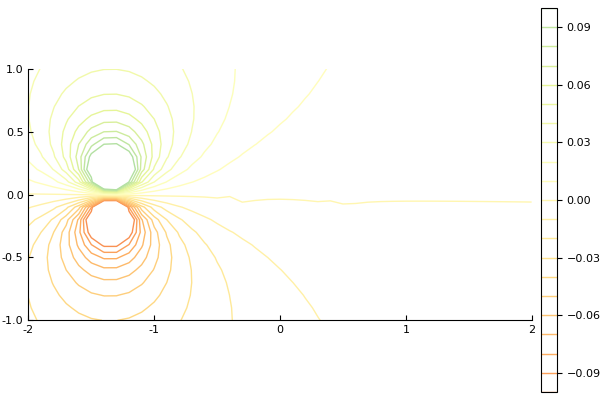

In [147]:
ψ = streamfunction(ζ, sys);
plot(xrange,yrange,ψ,seriestype=:contour,ratio=1,levels = collect(-0.1:0.01:0.1))

In [138]:
streamfunction(b.zs[10],sys)

-0.009433016478128359

In [151]:
rmax = 3.0
  eps = 0.00001;

  nth = 400;
  dth = 2π/nth;
  θ = linspace(0,2π,nth+1);
  dr = dth;
  r = [1+eps];
  while maximum(r) < rmax
    push!(r,r[end]+dr)
    dr = r[end]*dth;
  end
  
  ζ = r * exp.(im*θ');
Z = conftransform(ζ,b);

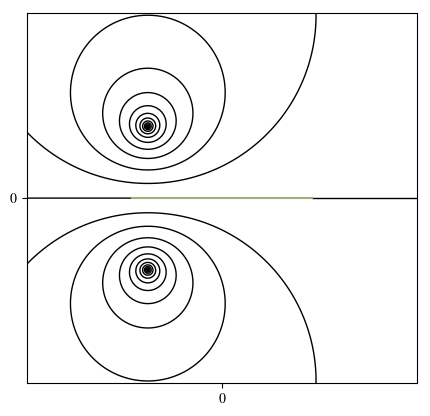

6.0


PyObject <matplotlib.contour.QuadContourSet object at 0x13e409ed0>

In [204]:
plot_streamlines(sys;scalefactor=3.0)

In [153]:
ψ = streamfunction(ζ, sys);

In [11]:
function transform_velocity!(wout,win,targets::T,b::PotentialFlow.ConformalBody) where T <: Union{Tuple,AbstractArray}
    for (i,target) in enumerate(targets)
        println("here 1",typeof(win[i]))
       wout[i] = transform_velocity(win[i],target,b) 
        println("here 2",typeof(wout[i]))
  end
  wout
end

function transform_velocity!(wout,win,targets::T,b::PotentialFlow.ConformalBody) where T <: Tuple
    for (i,target) in enumerate(targets)
        println("here 1",typeof(win[i]))
       transform_velocity!(wout[i],win[i],target,b) 
        println("here 2",typeof(wout[i]))
  end
  wout
end


#function transform_velocity!(wout,win,targ::T,b::PotentialFlow.ConformalBody) where T <: Union{Vortex.Blob,Vortex.Point}
#  println("hi")
#  _transform_velocity!(wout,win,targ,b,kind(targ))  
#  return wout
#end

#function transform_velocity!(wout,win,targ,b::PotentialFlow.ConformalBody)
#  return _transform_velocity(win,Elements.unwrap_targ(targ),b,kind(Elements.unwrap_targ(targ)))
#end

#function _transform_velocity(win,targ,b::PotentialFlow.ConformalBody, ::Type{Group})
#    wout = deepcopy(win)
#    for i in eachindex(targ)
#    wout[i] = _transform_velocity(win[i],targ[i],b,kind(targ[i]))
#  end
#    return wout
#end

function transform_velocity(win,targ::T,b::PotentialFlow.ConformalBody) where T <: Union{Vortex.Blob,Vortex.Point}
  println(targ) 
  println(win)
  wout = win  
  z̃ = b.m(targ.z)
  dz̃, ddz̃ = b.dm(targ.z)
  wout += targ.S*conj(ddz̃)/(4π*im*conj(dz̃))
  wout /= conj(dz̃)
  wout -= b.ċ + im*b.α̇*z̃
  wout /= dz̃
  println("here",wout) 
  wout  
end

function transform_velocity!(wout,win,targ::PotentialFlow.ConformalBody,b::PotentialFlow.ConformalBody)
    wout = win
end

transform_velocity! (generic function with 3 methods)

In [9]:
ẋtest = (motion,allocate_velocity(ambient_sys))

(Rigid Body Motion:
  ċ = 0.0 + 0.0im
  c̈ = 0.0 + 0.0im
  α̇ = 0.0
  Constant (ċ = 0.0 + 0.0im, α̇ = 0.0), Complex{Float64}[0.0+0.0im, 0.0+0.0im])

In [12]:
transform_velocity!(ẋtest,ẋs,sys,b)

here 1PotentialFlow.RigidBodyMotions.RigidBodyMotion
here 2PotentialFlow.RigidBodyMotions.RigidBodyMotion
here 1Array{Complex{Float64},1}
here 1Complex{Float64}
Vortex.Point(-7.158450365319121 + 0.09238389981697069im, 1.0)
0.8613664964372874 + 3.0649767764762137e-7im
here2.9406470001337532 + 0.0012313326256623517im
here 2Complex{Float64}
here 1Complex{Float64}
Vortex.Point(-7.158450365319121 - 0.09238389981697069im, -1.0)
0.8613664964372874 - 3.0649767764762137e-7im
here2.9406470001337532 - 0.0012313326256623517im
here 2Complex{Float64}
here 2Array{Complex{Float64},1}


(Rigid Body Motion:
  ċ = 0.0 + 0.0im
  c̈ = 0.0 + 0.0im
  α̇ = 0.0
  Constant (ċ = 0.0 + 0.0im, α̇ = 0.0), Complex{Float64}[2.94065+0.00123133im, 2.94065-0.00123133im])

In [236]:
ẋtest

(Rigid Body Motion:
  ċ = 0.0 + 0.0im
  c̈ = 0.0 + 0.0im
  α̇ = 0.0
  Constant (ċ = 0.0 + 0.0im, α̇ = 0.0), Complex{Float64}[0.0+0.0im, 0.0+0.0im])

In [172]:
function test1!(x)
    return test2(x)
end
function test2(x)
    return x + 2
end

test2 (generic function with 1 method)

In [174]:
x = 3
test1(x)

5

In [177]:
sys2 = deepcopy(sys)

(Body generated by: Schwarz-Christoffel map of unit circle to exterior of polygon with 12 vertices

  centroid at 0.0 + 0.0im
  angle 0.0
, PotentialFlow.Points.Point{Float64}[Vortex.Point(0.8548178488850584 + 0.5548714220486363im, 1.0), Vortex.Point(0.8548178488840068 - 0.5548714220509415im, -1.0)])